# Visual Explainability: Gradient-based methods

In [ ]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00


## Libraries

In [ ]:
import torch
from torchvision import models, transforms
from captum.attr import LayerGradCam
# Import visualize_image_attr from the correct submodule
from captum.attr._utils.visualization import visualize_image_attr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Load VGG16 pretrained on ImageNet
model = vgg16(pretrained=True)
model.eval()


NameError: name 'vgg16' is not defined

## 1. Grad-CAM

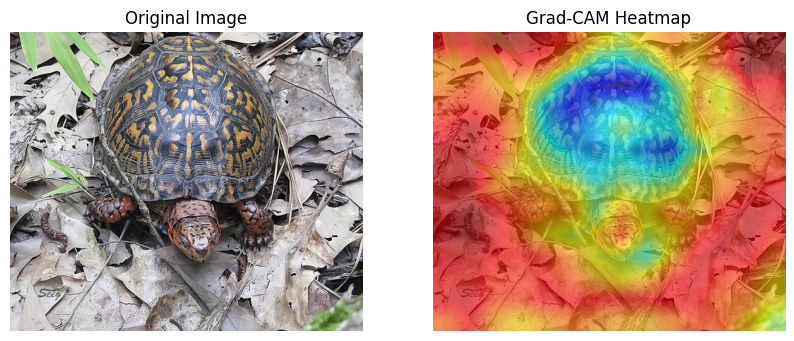

In [ ]:


# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image and apply transformations
image_path = '/content/tortle.JPEG'  # specify your image path
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Select target layer for Grad-CAM
target_layer = model.features[29]  # Last convolutional layer of VGG16

# Initialize LayerGradCam
layer_gc = LayerGradCam(model, target_layer)

# Select class index to explain, if None, the predicted class will be explained
with torch.no_grad():
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

# Generate Grad-CAM attributions
attributions = layer_gc.attribute(input_tensor, target=class_idx)

# Upsample Grad-CAM to match input image size
def visualize_gradcam(attributions, original_image, colormap=cv2.COLORMAP_JET, alpha=0.6):
    # Convert attributions to numpy and resize to original image size
    heatmap = attributions.squeeze().cpu().detach().numpy()
    heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))

    # Normalize the heatmap between 0 and 1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Overlay heatmap on top of the original image
    original_image_np = np.array(original_image)
    overlay = cv2.addWeighted(original_image_np, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Visualize and plot the result
overlay_image = visualize_gradcam(attributions, image)

# Plot original and overlay images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title("Original Image")
ax[1].imshow(overlay_image)
ax[1].axis('off')
ax[1].set_title("Grad-CAM Heatmap")
plt.show()


## 2. DeepLIFT

In [ ]:
import torch
from torchvision import models, transforms
from captum.attr import DeepLift
from captum.attr._utils.visualization import visualize_image_attr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Load the VGG16 model pretrained on ImageNet
model = models.vgg16(pretrained=True)
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

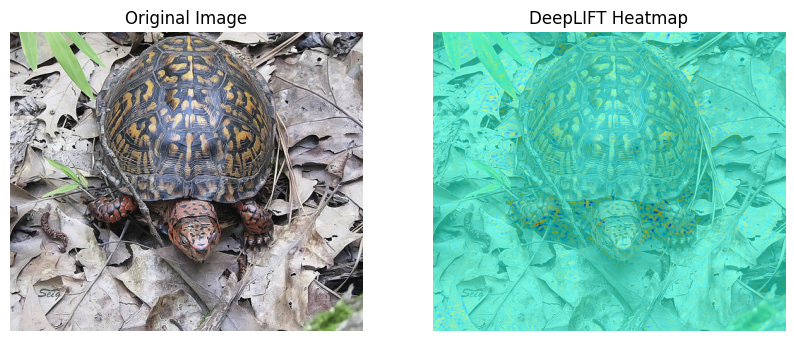

In [ ]:

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the input image and apply transformations
image_path = '/content/tortle.JPEG'  # specify your image path
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Initialize DeepLift
deeplift = DeepLift(model)

# Define the target class to explain; use predicted class if not specified
with torch.no_grad():
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

# Use a zero tensor as the baseline (reference input)
baseline = torch.zeros_like(input_tensor)

# Compute DeepLIFT attributions
attributions = deeplift.attribute(input_tensor, baseline, target=class_idx)

def visualize_deeplift(attributions, original_image, alpha=0.6):
    # Convert attributions to numpy and resize to match original image
    heatmap = attributions.squeeze().cpu().detach().numpy()
    heatmap = np.mean(heatmap, axis=0)  # Take the mean across RGB channels
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize to [0, 1]

    # Convert heatmap to 255 scale and resize, ensuring 3 channels
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))  # Resize heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap for better visualization
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Convert to RGB if the original image is RGB

    # Overlay on original image
    overlay = cv2.addWeighted(np.array(original_image), 1 - alpha, heatmap, alpha, 0)

    return overlay

# Plot original and overlay images
overlay_image = visualize_deeplift(attributions, image)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title("Original Image")
ax[1].imshow(overlay_image)
ax[1].axis('off')
ax[1].set_title("DeepLIFT Heatmap")
plt.show()


## 3. LRP (Layer-wise Relevance Propagation)

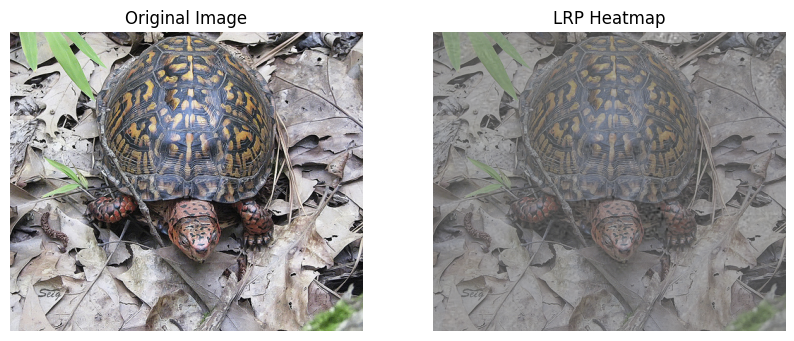

In [ ]:
import torch
from torchvision import models, transforms
from captum.attr import LRP
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the VGG16 model pretrained on ImageNet
model = models.vgg16(pretrained=True)
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the input image and apply transformations
image_path = '/content/tortle.JPEG'  # specify your image path
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Initialize LRP
lrp = LRP(model)

# Define the target class to explain; use predicted class if not specified
with torch.no_grad():
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

# Compute LRP attributions
attributions = lrp.attribute(input_tensor, target=class_idx)

# Visualization function to overlay heatmap on the original image
def visualize_lrp(attributions, original_image, alpha=0.6):
    # Convert attributions to numpy and resize to match original image
    heatmap = attributions.squeeze().cpu().detach().numpy()
    heatmap = np.mean(heatmap, axis=0)  # Take the mean across RGB channels
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize to [0, 1]

    # Convert heatmap to 255 scale and overlay on original image
    heatmap = np.uint8(255 * heatmap)

    # Resize heatmap to match original image shape (height, width)
    heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))

    # Convert the original PIL image to a NumPy array with 3 channels (if necessary)
    original_image_np = np.array(original_image)
    if original_image_np.ndim == 2:  # If grayscale, convert to 3 channels
        original_image_np = cv2.cvtColor(original_image_np, cv2.COLOR_GRAY2BGR)

    # Ensure both images have the same number of channels
    if heatmap.ndim == 2 and original_image_np.ndim == 3:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2BGR)
    elif heatmap.ndim == 3 and original_image_np.ndim == 2:
        original_image_np = cv2.cvtColor(original_image_np, cv2.COLOR_GRAY2BGR)

    overlay = cv2.addWeighted(original_image_np, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Plot original and overlay images
overlay_image = visualize_lrp(attributions, image)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title("Original Image")
ax[1].imshow(overlay_image)
ax[1].axis('off')
ax[1].set_title("LRP Heatmap")
plt.show()


## 4. Integrated Gradient

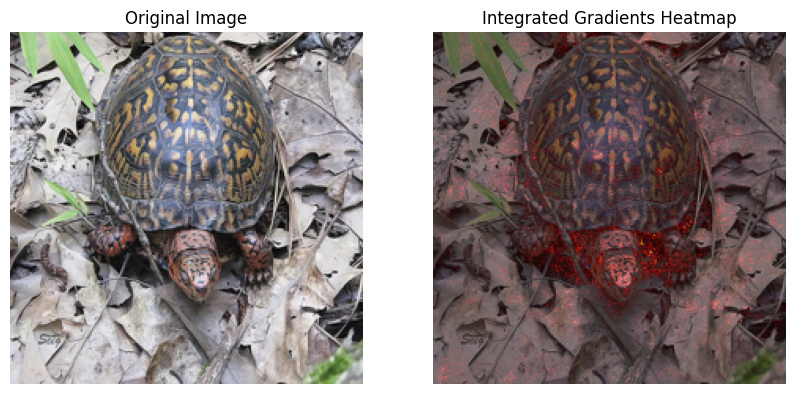

In [ ]:
import torch
from torchvision import models, transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load VGG16 pretrained on ImageNet
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing transformations for VGG16
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
def load_image(image_path):
    img = Image.open(image_path)
    img = preprocess(img)
    return img.unsqueeze(0)  # Add batch dimension

image_path = "/content/tortle.JPEG"  # Replace with your image path
input_image = load_image(image_path)

# Define the target class (e.g., class index for "cat" or "dog")
target_class = 243  # Replace with the target class index for your image

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Apply Integrated Gradients
attributions, delta = ig.attribute(input_image, target=target_class, baselines=input_image * 0, return_convergence_delta=True)

# Convert attributions to numpy for visualization
attributions = attributions.squeeze().cpu().detach().numpy()
attributions = np.transpose(attributions, (1, 2, 0))  # CHW to HWC

# Aggregate channels to form a heatmap
attributions = np.mean(np.abs(attributions), axis=2)

# Normalize the attributions for visualization
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

# Plot the original image and attributions
def visualize_image_attr(attr, original_image_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    original_image = Image.open(original_image_path).resize((224, 224))
    ax1.imshow(original_image)
    ax1.axis('off')
    ax1.set_title('Original Image')

    # Attribution heatmap
    ax2.imshow(original_image)
    ax2.imshow(attr, cmap='hot', alpha=0.5)  # Overlay heatmap
    ax2.axis('off')
    ax2.set_title('Integrated Gradients Heatmap')

    plt.show()

# Visualize the attributions
visualize_image_attr(attributions, image_path)
